# Aries Basic Controller - Verifier

## This notebook works through the present proof protocol from the Verifier's perspective, it should be run alongside the Issuer notebook from an Issuer's perspective. 

If unfamiliar with the present-proof protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0037-present-proof)


## Import packages

In [1]:
!pip install termcolor
!pip install pillow
!pip install qrcode
from termcolor import colored,cprint

## 1. Instatiate Controller for Verifiers's Agent

In [2]:
%autoawait
import time
import asyncio
from aries_basic_controller.aries_controller import AriesAgentController

WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://verifier-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)


IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic present_proof, printing out the payload. The agent calls to this webhook every time it receives a present proof protocol message from another agent. 

The code for this protocol can be found [here](https://github.com/hyperledger/aries-cloudagent-python/tree/master/aries_cloudagent/protocols/issue_credential).

In [3]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def messages_handler(payload):
    connection_id = payload["connection_id"]
    asyncio.get_event_loop().create_task(agent_controller.messaging.send_message(connection_id, "This is a response from Bob"))
    print("Handle message", payload, connection_id)


message_listener = {
    "handler": messages_handler,
    "topic": "basicmessages"
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}

agent_controller.register_listeners([cred_listener,message_listener,connection_listener,proof_listener], defaults=True)



## 3. Make a connection with a Users Mobile SSI Wallet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 4. Create a connection invitation to scan with the Mobile SSI Wallet

## 4a. Check for any existing connections

In [5]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS


## 4b. Create an Invitation

In [6]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection ID 066558a3-a87f-460d-87ad-9cfe7a372554
Invitation
https://a73e1e519ad2.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNGYxYzUwMTItYWM2MC00Zjk5LWExZTAtYWY5NTAzNWQ3NGY4IiwgImxhYmVsIjogIlZlcmlmaWVyIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovL2E3M2UxZTUxOWFkMi5uZ3Jvay5pbyIsICJyZWNpcGllbnRLZXlzIjogWyJGcWhQblBRbmhnWGdkWG1vc0ZSYzVWWUY5eUZjMmhodkZSd3RIa2d5Nm5DMSJdfQ==
Connection message {'initiator': 'self', 'connection_id': '066558a3-a87f-460d-87ad-9cfe7a372554', 'accept': 'auto', 'routing_state': 'none', 'state': 'invitation', 'created_at': '2020-09-16 10:21:26.061794Z', 'invitation_key': 'FqhPnPQnhgXgdXmosFRc5VYF9yFc2hhvFRwtHkgy6nC1', 'updated_at': '2020-09-16 10:21:26.061794Z', 'invitation_mode': 'once'} 066558a3-a87f-460d-87ad-9cfe7a372554


## 4c. Generate QR Code to be scanned with Mobile SSI Wallet

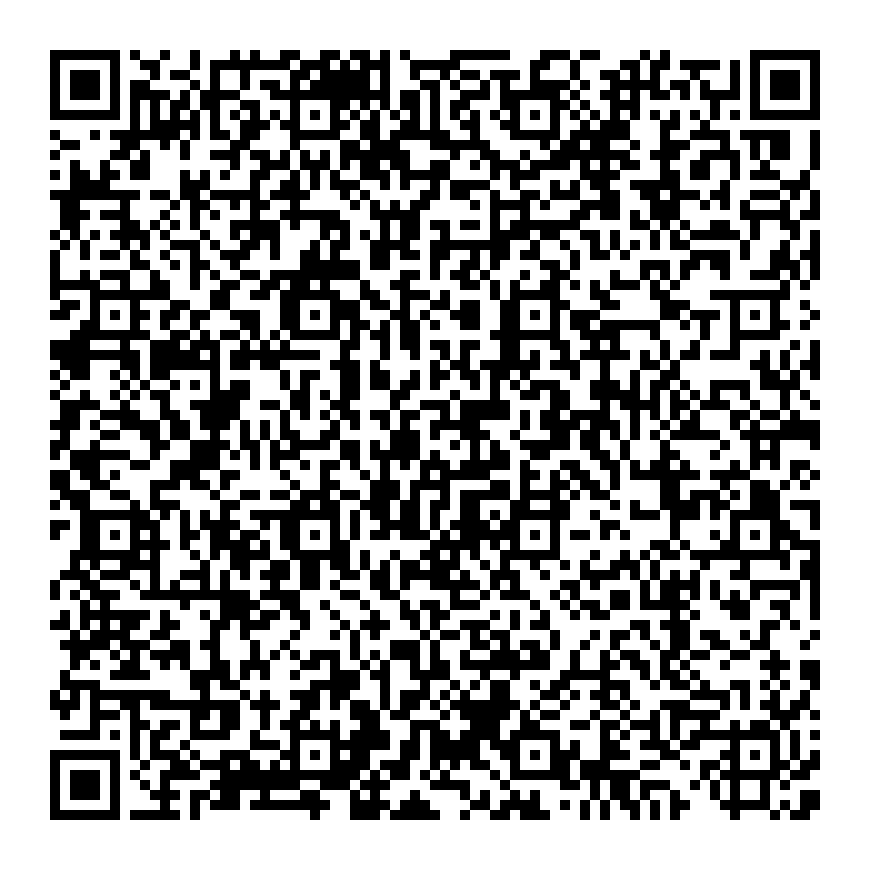

Connection message {'initiator': 'self', 'connection_id': '066558a3-a87f-460d-87ad-9cfe7a372554', 'their_label': 'EAX', 'accept': 'auto', 'routing_state': 'none', 'their_did': 'RQuWi5UovUdhvobwHUXmmH', 'state': 'request', 'created_at': '2020-09-16 10:21:26.061794Z', 'invitation_key': 'FqhPnPQnhgXgdXmosFRc5VYF9yFc2hhvFRwtHkgy6nC1', 'updated_at': '2020-09-16 10:21:37.422554Z', 'invitation_mode': 'once'} 066558a3-a87f-460d-87ad-9cfe7a372554
Connection message {'initiator': 'self', 'connection_id': '066558a3-a87f-460d-87ad-9cfe7a372554', 'their_label': 'EAX', 'accept': 'auto', 'routing_state': 'none', 'their_did': 'RQuWi5UovUdhvobwHUXmmH', 'state': 'response', 'my_did': 'SvszLx42D5wtdW7iyE15SD', 'created_at': '2020-09-16 10:21:26.061794Z', 'invitation_key': 'FqhPnPQnhgXgdXmosFRc5VYF9yFc2hhvFRwtHkgy6nC1', 'updated_at': '2020-09-16 10:21:37.457941Z', 'invitation_mode': 'once'} 066558a3-a87f-460d-87ad-9cfe7a372554


In [7]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## 4d. Check if established connection is in active state

In [8]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 066558a3-a87f-460d-87ad-9cfe7a372554 is response
ConnectionId 066558a3-a87f-460d-87ad-9cfe7a372554 is not in active state yet
Trust ping send to ConnectionId {'thread_id': 'a27f1cce-7a2b-452c-b4f3-fab3a36ea6ce'} to activate connection
ConnectionId 066558a3-a87f-460d-87ad-9cfe7a372554 is not in active state yet
Connection message {'initiator': 'self', 'connection_id': '066558a3-a87f-460d-87ad-9cfe7a372554', 'their_label': 'EAX', 'accept': 'auto', 'routing_state': 'none', 'their_did': 'RQuWi5UovUdhvobwHUXmmH', 'state': 'active', 'my_did': 'SvszLx42D5wtdW7iyE15SD', 'created_at': '2020-09-16 10:21:26.061794Z', 'invitation_key': 'FqhPnPQnhgXgdXmosFRc5VYF9yFc2hhvFRwtHkgy6nC1', 'updated_at': '2020-09-16 10:21:44.512617Z', 'invitation_mode': 'once'} 066558a3-a87f-460d-87ad-9cfe7a372554
Connection 066558a3-a87f-460d-87ad-9cfe7a372554 changed state to active
Trust ping send to ConnectionId {'thread_id': 'd8c39445-a11d-4cd4-90d4-8a924806a6bd'} to activate connection

## 5. Send Proof Request to Identity Holder Mobile Wallet

## 5a. Generate Proof Request

In [12]:
from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://issuer-agent:8021"

# Based on the aca-py agent you wish to control
issuer_agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)

response = await issuer_agent_controller.wallet.get_public_did()
print(response)
issuer_did = response["result"]["did"]

print("Request proof of Name and Age range from Identity Holder")
#Set some variables

revocation = False
SELF_ATTESTED = True
exchange_tracing = False

#Enable this to ask for attributes to identity a user
req_attrs = [
    {"name": "name", "restrictions": [{"issuer_did": issuer_did}]},
    {"name": "skill", "restrictions": [{"issuer_did": issuer_did}]},
]

if revocation:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"issuer_did": agent.did}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = [
    # test zero-knowledge proofs
    {
        "name": "age",
        "p_type": ">=",
        "p_value": 21,
        "restrictions": [{"issuer_did": issuer_did}],
    }
]

indy_proof_request = {
    "name": "Proof of Personal Information",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if revocation:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = exchange_tracing
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": exchange_tracing,
}

{'result': {'did': 'JiMfFgbgMoshKLYZiAu7mq', 'verkey': 'Aewkn2W36twEskEYz87gHzAbcRexGWqYXM7CoRGRG5Ly', 'public': True}}
Request proof of Name and Age range from Identity Holder


### 5b. Send the proof request to Identity Holder

Identity Holder is identified through the connection_id

In [13]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)


{'initiator': 'self', 'connection_id': '066558a3-a87f-460d-87ad-9cfe7a372554', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': '3c3b88b1-d526-4e13-b5c1-858c7c3b097a', 'request_presentations~attach': [{'@id': 'libindy-request-presentation-0', 'mime-type': 'application/json', 'data': {'base64': 'eyJuYW1lIjogIlByb29mIG9mIFBlcnNvbmFsIEluZm9ybWF0aW9uIiwgInZlcnNpb24iOiAiMS4wIiwgInJlcXVlc3RlZF9hdHRyaWJ1dGVzIjogeyIwX25hbWVfdXVpZCI6IHsibmFtZSI6ICJuYW1lIiwgInJlc3RyaWN0aW9ucyI6IFt7Imlzc3Vlcl9kaWQiOiAiSmlNZkZnYmdNb3NoS0xZWmlBdTdtcSJ9XX0sICIwX3NraWxsX3V1aWQiOiB7Im5hbWUiOiAic2tpbGwiLCAicmVzdHJpY3Rpb25zIjogW3siaXNzdWVyX2RpZCI6ICJKaU1mRmdiZ01vc2hLTFlaaUF1N21xIn1dfSwgIjBfY291bnRyeV91dWlkIjogeyJuYW1lIjogImNvdW50cnkifX0sICJyZXF1ZXN0ZWRfcHJlZGljYXRlcyI6IHsiMF9hZ2VfR0VfdXVpZCI6IHsibmFtZSI6ICJhZ2UiLCAicF90eXBlIjogIj49IiwgInBfdmFsdWUiOiAyMSwgInJlc3RyaWN0aW9ucyI6IFt7Imlzc3Vlcl9kaWQiOiAiSmlNZkZnYmdNb3NoS0xZWmlBdTdtcSJ9XX19LCAibm9uY2UiO

## 6. Verify Proof Presentation

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger.

In [23]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)
print(verify)

ClientResponseError: 400, message='Presentation exchange 45b71dc6-4136-4c06-b1a8-5d61d3ad7cb1 in verified state (must be presentation_received)', url=URL('http://verifier-agent:8051/present-proof/records/45b71dc6-4136-4c06-b1a8-5d61d3ad7cb1/verify-presentation')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.py", line 112, in print_formatted_text
    output = get_app_session().output
  File "/opt/conda/lib/

## End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [26]:
response = await issuer_agent_controller.terminate()
print(response)
response = await agent_controller.terminate()
print(response)

None


NameError: name 'bob_agent_controller' is not defined